# Importation des données

In [1]:
import os
import string
import re
import math
import statistics
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
from collections import Counter
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
nom_dossier = "100k"
nom_dossier = "ens" #ou

On ne garde ici que les 100 000 premiers tweets

In [2]:
# Penser à changer selon taille
with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
phrases = ens_tweets
print(len(phrases))

1348627


In [3]:
words = [item for sublist in phrases for item in sublist]
print(type(words))
vocabulary = list(dict.fromkeys(words))
with open("data/%s/vocabulary.file" %nom_dossier, "wb") as f:
    pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))

<class 'list'>
Nombre de mots : 31390592
Taille du vocabulaire : 70330


Les 10 mots les plus communs sont :
[('nickname', 1542945), ('de', 1097380), ('lowfrequencyword', 1082919), ('le', 712091), ('est', 589701), ('je', 541570), ('les', 509159), ('c', 493644), ('la', 485258), ('j', 475754)]


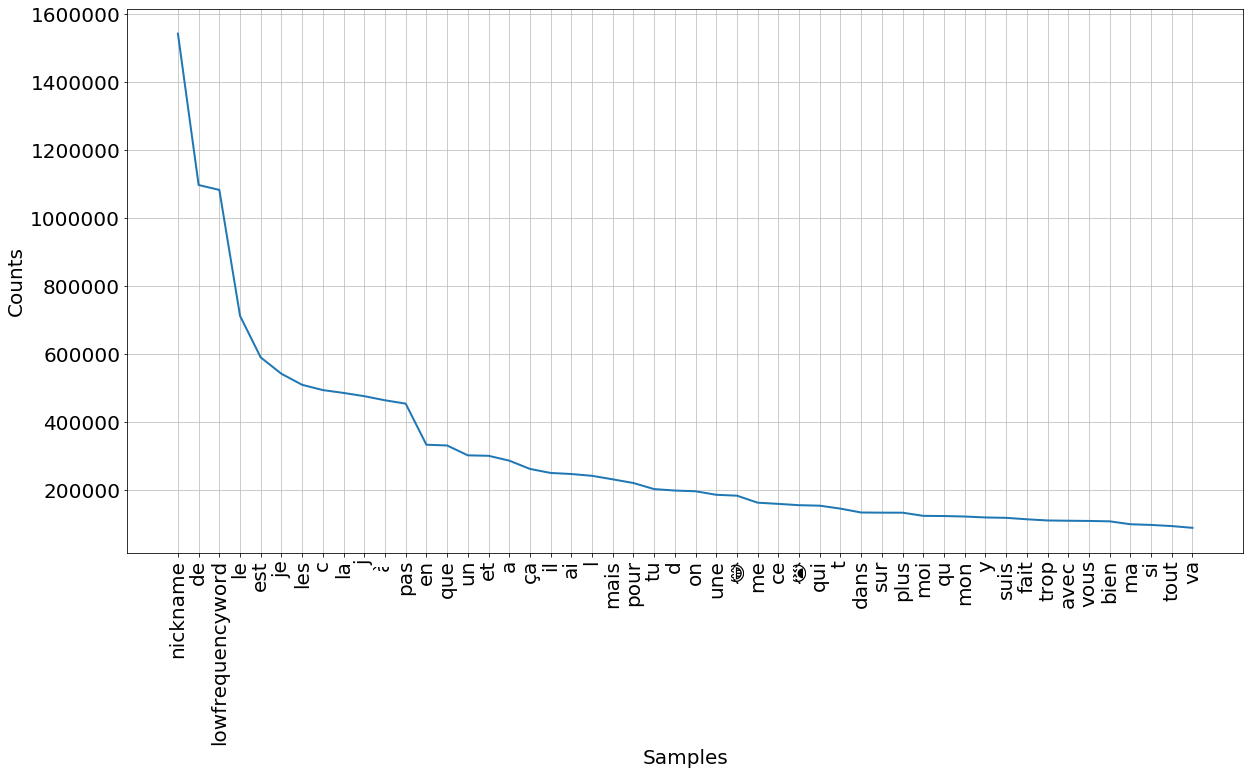

In [4]:
# Pour changer la taille des graphiques :
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20

fdist = nltk.FreqDist(words)
print("Les 10 mots les plus communs sont :")
print(fdist.most_common(10))
fdist.plot(50)

In [5]:
mots_non_tires = Counter(["subsampledword", "nickname", "lowfrequencyword"])

In [6]:
def motContexteExiste(phrase, indice, focus, window):
    reponse = False
    debut = max(indice-window,0)
    fin = min(indice+window+1, len(phrase))
    for mot in phrase[debut:fin]:
        if mot not in mots_non_tires and mot != focus:
            reponse = True
            break;
    return(reponse)

#Fonction pour vérifier si phrase OK ie si y a au moins un couple focus/context
def phraseVeri(phrase, window):
    phraseOk = False
    indice = -1
    for mot in phrase:
        indice = indice + 1
        if mot not in mots_non_tires:
            if(motContexteExiste(phrase,indice,mot,window)):
                phraseOk = True
                break;
    return(phraseOk)
listeTest = ["test","subsampledword","lowfrequencyword","ok","subsampledword"]
listeTestBis = ["test"]
print(phraseVeri(listeTest,2)) # Pas de couple focus/context pour une fenetre de 2
print(phraseVeri(listeTest,3)) # Il y a au moins un couple focus/context pour une fenetre de 3

False
True


# Sampling rate et negative sampling
On va simplifier un peu le corpus en enlevant certains mots. Pour cela on va faire un sous-échantillonnage du corpus pour supprimer certains mots. 

Pour chaque mot $w_i$ on note $z(w_i)$ la proportion d'apparition de ce mot, c'est-à-dire le rapport entre le nombre de fois que ce mot apparait et le nombre total de mots. La probabilité de garder un mot le mot $w_i$ est :
$$
\mathbb P(w_i) = \left(\sqrt{\frac{z(w_i)}{q}} + 1 \right)
\times
\frac{q}{z(w_i)}
$$
Le paramètre $q$ est appelé "sample" – échantillonnage – contrôle le nombre de sous-échantillonnages. La valeur par défaut est 0,001.

In [7]:
def calcul_proba(x):
    result = (sqrt(x)+1)*(1/x)
    return(result)
calcul_proba_v = np.vectorize(calcul_proba) # Pour vectoriser la fonction
# Fonction pour créer l'échantillon
def creer_echantillon(phrases, mot_index, probabilities_subsampling, window,
                    vec_neg_sampling, K = 5):
    #Sub-sampling
    def sub_sampling(phrase):
        res = []
        for word in phrase: #et pour tous les mots de l'article
        # Les mots à supprimer sont les mots tels que la loi générée U([0,1]) soit > proba
        # On garde donc les mots si U([0,1]) <= proba
            proba_w = probabilities_subsampling[mot_index[word]]
            if np.random.uniform(low=0.0, high=1.0) <= proba_w: # Je garde le mot
                res.append(word)
            else:
                res.append("subsampledword")
        return(res)
    nouveau_corpus = list(map(sub_sampling, phrases)) 
    #nouveau_corpus = Parallel(n_jobs=num_cores)(delayed(sub_sampling)(phrase) for phrase in phrases)

    phrases = [phrase for phrase in nouveau_corpus if phraseVeri(phrase,window)] # On enlève les phrases avec 1 seul mot
    def tirage_f_c(phrase):
        while True:
        # Pour chaque phrase on prend au hasard un mot focus et un mot contexte
            focus = np.random.randint(0, len(phrase))
            contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
            while(contexte == focus):
                contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
            if (phrase[focus] not in mots_non_tires 
                and phrase[contexte] not in mots_non_tires):
                index_i = mot_index[phrase[focus]]
                index_j = mot_index[phrase[contexte]]
                neg_sample = tirage_neg_sampling(vec_neg_sampling, K = K)
                break
        return([index_i, index_j, neg_sample])
    #test_sample = Parallel(n_jobs=num_cores)(delayed(tirage_f_c)(phrase) for phrase in phrases)
    test_sample = map(tirage_f_c, phrases)
    return(list(test_sample))

################################
## On fixe un paramètre ici ####
sample = 0.001
proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
p_subsampling = calcul_proba_v(proportion) # C'est le vecteur contenant les proba de sub-sampling

Pour le négative sampling, la probabilité de garder le mot $w_i$ est égale à :
$$
\mathbb P(w_i) = \frac{f(w_i)^{3/4}}{
\sum_{j=1}^n f(w_j)^{3/4}
}
$$
Avec $f(w_j)$ la fréquence d'apparition du mot $w_j$.

In [8]:
################################
## On fixe un paramètre ici ####

p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
# On met à 0 la proba de tirer les mots "nickname" et "lowfrequencyword" en negative sampling
p_negativesampling[[mot_index[w] for w in ["nickname", "lowfrequencyword"]]] = 0
p_negativesampling /= p_negativesampling.sum()

In [9]:
# Fonction de tirage des mots du negative sampling
#def tirage_neg_sampling(vocabulary, proba_negativesampling, focus, context, K = 5):
#    #proba_negativesampling[focus] = 0
#    #proba_negativesampling[context] = 0
#    liste_vocab = list(range(len(vocabulary)))
#    neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
#   # while( (focus in neg_sampling) | (context in neg_sampling)):
#   #     neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
#    return(neg_sampling)
def tirage_neg_sampling(vec_neg_sampling, K = 5):
    neg_sampling = vec_neg_sampling[np.random.randint(0, len(vec_neg_sampling), size = K)]
    return(neg_sampling)
def creation_vecteur_neg_sampling(p_negativesampling, taille_tot = 100000000):
    # On va créer un vecteur de taille environ égale à taille_tot où on va répéter 
    # p_negativesampling[i] * taille_tot chaque indice i
    # Par exemple, si taille_tot = 10, p_negativesampling = [0.5, 0.2, 0.3] on veut :
    # [0, 0, 0, 0, 0, 1, 1, 2, 2, 2]
    # Ensuite pour le négative sampling, on va tirer un élément au hasard de cette liste
    # qui va nous donner l'indice dans le vocabulaire du mot tiré par le négative sampling.
    # Dans l'exemple précédent on tire l'indice 0 avec une proba 0.5 (5 chance sur 10), c'est bien cohérent
    def rep_indice(i):
        # [i] * n répète n fois l'éléménet i
        return([i] * int(round(p_negativesampling[i] * taille_tot)))
    vec_neg_sampling = map(rep_indice, list(range(len(p_negativesampling))))
    vec_neg_sampling = list(vec_neg_sampling)
    # On veut un array à la fin, pour l'instant on a une liste de liste, si on reprend l'exemple précédent
    # on a : [[1, 1, 1, 1, 1], [2, 2], [3, 3, 3]]
    vec_neg_sampling = np.array([y for x in vec_neg_sampling for y in x], dtype = int)
    return(vec_neg_sampling)
vec_neg_sampling = creation_vecteur_neg_sampling(p_negativesampling, taille_tot = 100000000)
vec_neg_sampling

array([    0,     0,     0, ..., 70329, 70329, 70329])

# Extraction des echantillons


In [20]:
temps_par_window = []
K = 5
epochs = 10

start = time.time()
for window in [5, 6]:
    random.seed(1)
    np.random.seed(1)
    print("window ", window)
    start_window = time.time()
    if not os.path.exists("data/%s/window_%i" %(nom_dossier, window)):
        os.mkdir("data/%s/window_%i" %(nom_dossier, window))
 
    for i in range(epochs):
        print("data/%s/window_%i/epoch_%i.file" %(nom_dossier, window, i))
        test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window,
                                             vec_neg_sampling, K = K)
        
        with open("data/%s/window_%i/epoch_%i.file" %(nom_dossier, window, i), "wb") as f:
            pickle.dump(test_sample, f, pickle.HIGHEST_PROTOCOL)
        
    end_window = time.time()
    temps_par_window.append(end_window - start_window)
    print(round((end_window - start_window)/60, 2))
end = time.time()
print(round((end - start)/60, 2))

window  5
data/ens/window_5/epoch_0.file
data/ens/window_5/epoch_1.file
data/ens/window_5/epoch_2.file
data/ens/window_5/epoch_3.file
data/ens/window_5/epoch_4.file
data/ens/window_5/epoch_5.file
data/ens/window_5/epoch_6.file
data/ens/window_5/epoch_7.file
data/ens/window_5/epoch_8.file
data/ens/window_5/epoch_9.file
45.7
window  6
data/ens/window_6/epoch_0.file
data/ens/window_6/epoch_1.file
data/ens/window_6/epoch_2.file
data/ens/window_6/epoch_3.file
data/ens/window_6/epoch_4.file
data/ens/window_6/epoch_5.file
data/ens/window_6/epoch_6.file
data/ens/window_6/epoch_7.file
data/ens/window_6/epoch_8.file
data/ens/window_6/epoch_9.file
37.04
82.74


In [16]:
with open("data/%s/window_%ibis/epoch_%i.file" %(nom_dossier, 3, 0), "rb") as f:
    test_sample2 = pickle.load(f) 
test_sample2

[[1, 4, array([ 1619,  9170,   893,  4170, 11484])],
 [19, 20, array([ 1356, 25953,   278,  3239,  1074])],
 [23, 22, array([ 471,    7,  379,   41, 1924])],
 [28, 5, array([49799, 22462,   116,   543,   499])],
 [41, 40, array([  692,  3158,   693, 43199, 32682])],
 [50, 49, array([  610,  4650,   149,    95, 66958])],
 [58, 56, array([   15,   236,  6319, 12263,  3235])],
 [66, 18, array([   54,   109, 29961,   238, 31911])],
 [73, 7, array([ 1590, 24874,    18, 20789,  1804])],
 [0, 78, array([  388,    43, 14240,   273, 18769])],
 [83, 82, array([  13, 2173,   43, 4504,  324])],
 [84, 29, array([  614, 12567, 13998,  2805,  2568])],
 [87, 86, array([  655,    12,   506, 43479,    13])],
 [101, 98, array([ 4836,   289, 14879, 23965,    11])],
 [103, 102, array([16695,    73, 22112, 15087,   298])],
 [104, 106, array([13581,  2748, 10911,  2171,  7496])],
 [118, 15, array([ 1103,   363,  4858, 38208,  2628])],
 [60, 121, array([69396,  2761,  2324, 22549,   352])],
 [127, 126, array(

In [19]:
test_sample 

[[1, 4, array([ 1619,  9170,   893,  4170, 11484])],
 [19, 20, array([ 1356, 25953,   278,  3239,  1074])],
 [23, 22, array([ 471,    7,  379,   41, 1924])],
 [28, 5, array([49799, 22462,   116,   543,   499])],
 [41, 40, array([  692,  3158,   693, 43199, 32682])],
 [50, 49, array([  610,  4650,   149,    95, 66958])],
 [58, 56, array([   15,   236,  6319, 12263,  3235])],
 [66, 18, array([   54,   109, 29961,   238, 31911])],
 [73, 7, array([ 1590, 24874,    18, 20789,  1804])],
 [0, 78, array([  388,    43, 14240,   273, 18769])],
 [83, 82, array([  13, 2173,   43, 4504,  324])],
 [84, 29, array([  614, 12567, 13998,  2805,  2568])],
 [87, 86, array([  655,    12,   506, 43479,    13])],
 [101, 98, array([ 4836,   289, 14879, 23965,    11])],
 [103, 102, array([16695,    73, 22112, 15087,   298])],
 [104, 106, array([13581,  2748, 10911,  2171,  7496])],
 [118, 15, array([ 1103,   363,  4858, 38208,  2628])],
 [60, 121, array([69396,  2761,  2324, 22549,   352])],
 [127, 126, array(

In [36]:
# Quelques tests si on veut changer le tirage
focus_possibles = list(range(0, len(phrase)))
focus_possibles = [i for i in focus_possibles if phrase[i] not in mots_non_tires]
focus = np.random.randint(0, len(focus_possibles))
focus

7